### This notebook shows examples of how to use the cyclops.query API on MIMIC-IV.

## Example 1. Get all patient encounters from 2015.

In [14]:
from sqlalchemy import select

from cyclops.query import mimic
from cyclops.query import utils as query_utils
from cyclops.query.interface import QueryInterface

patients = mimic.patients(years=[2015])
patients.run()
print(f"{len(patients.data)} rows extracted!")

2022-04-21 10:55:15,104 INFO cyclops.orm     - Query returned successfully!
2022-04-21 10:55:15,105 INFO cyclops.utils.profile - Finished executing function run_query in 1.143282 s


98084 rows extracted!


## Example 2. Get all patient encounters with diagnoses (`schizophrenia` in ICD long title), in the year 2015.

In [2]:
patients = mimic.patients(years=[2015])
patients_schizophrenia = mimic.diagnoses(substring="schizophrenia", patients=patients)
patients_schizophrenia.run()
print(f"{len(patients_schizophrenia.data)} rows extracted!")
patients_schizophrenia.data["icd_title"].value_counts()

2022-04-21 10:52:13,476 INFO cyclops.orm     - Query returned successfully!
2022-04-21 10:52:13,477 INFO cyclops.utils.profile - Finished executing function run_query in 0.526777 s


5239 rows extracted!


Schizophrenia, unspecified                                                 3116
Unspecified schizophrenia, unspecified                                      954
Paranoid schizophrenia                                                      451
Unspecified schizophrenia, chronic                                          153
Paranoid type schizophrenia, unspecified                                    123
Catatonic schizophrenia                                                     103
Catatonic type schizophrenia, unspecified                                    65
Paranoid type schizophrenia, chronic with acute exacerbation                 52
Other schizophrenia                                                          43
Paranoid type schizophrenia, chronic                                         35
Other specified types of schizophrenia, chronic with acute exacerbation      26
Other specified types of schizophrenia, unspecified                          25
Catatonic type schizophrenia, chronic   

## Example 3. Advanced - uses regexp_match from sqlalchemy. Get all patient encounters with diagnoses (ICD long title contains `schizophrenia` and `chronic` ), in the year 2015.

In [3]:
patients = mimic.patients(years=[2015])
diagnoses = mimic.diagnoses(patients=patients)
subquery = (
    select(diagnoses.query)
    .where(diagnoses.query.c.icd_title.regexp_match("(?=.*schizophrenia)(?=.*chronic)"))
    .subquery()
)
patients_schizophrenia_chronic = diagnoses
patients_schizophrenia_chronic.query = subquery
patients_schizophrenia_chronic.run()
print(f"{len(patients_schizophrenia_chronic.data)} rows extracted!")

2022-04-21 10:52:14,605 INFO cyclops.orm     - Query returned successfully!
2022-04-21 10:52:14,606 INFO cyclops.utils.profile - Finished executing function run_query in 1.108281 s


310 rows extracted!


## Example 4. Advanced - uses cyclops.query.utils.starts_with helper function. Get all patient encounters with diagnoses (starts with `Paranoid` in ICD long title), in the year 2015.

In [4]:
patients = mimic.patients(years=[2015])
diagnoses = mimic.diagnoses(patients=patients)
subquery = (
    select(diagnoses.query)
    .where(query_utils.starts_with(diagnoses.query.c.icd_title, "Paranoid"))
    .subquery()
)
patients_schizophrenia = diagnoses
patients_schizophrenia.query = subquery
patients_schizophrenia.run()
print(f"{len(patients_schizophrenia.data)} rows extracted!")

2022-04-21 10:52:18,634 INFO cyclops.orm     - Query returned successfully!
2022-04-21 10:52:18,635 INFO cyclops.utils.profile - Finished executing function run_query in 4.009678 s


710 rows extracted!


## Example 5. Get all patient encounters with diagnoses (ICD code is F209).

In [5]:
patients = mimic.patients()
patients_f209 = mimic.diagnoses(diagnosis_codes=["F209"], patients=patients)
patients_f209.run()
print(f"{len(patients_f209.data)} rows extracted!")

2022-04-21 10:52:20,465 INFO cyclops.orm     - Query returned successfully!
2022-04-21 10:52:20,466 INFO cyclops.utils.profile - Finished executing function run_query in 1.817467 s


14818 rows extracted!


## Example 6. Get all patient encounters with diagnoses (`delirium` in ICD long title).

In [6]:
patients = mimic.patients()
patients_delirium = mimic.diagnoses(substring="delirium", patients=patients)
patients_delirium.run()
print(f"{len(patients_delirium.data)} rows extracted!")

2022-04-21 10:52:21,961 INFO cyclops.orm     - Query returned successfully!
2022-04-21 10:52:21,963 INFO cyclops.utils.profile - Finished executing function run_query in 1.474648 s


52482 rows extracted!


## Example 7. Get routine vital signs for patients from year 2015, limit to 100 rows.

In [7]:
patients = mimic.patients(years=[2015])
patients_vitals = mimic.events(category="Routine Vital Signs", patients=patients)
patients_vitals.run(limit=100)
print(f"{len(patients_vitals.data)} rows extracted!")

2022-04-21 10:53:21,557 INFO cyclops.orm     - Query returned successfully!
2022-04-21 10:53:21,559 INFO cyclops.utils.profile - Finished executing function run_query in 59.586411 s


100 rows extracted!


## Example 8. Get sodium lab tests for patients from year 2009, limit to 100 rows.

In [8]:
patients = mimic.patients(years=[2009])
patients_sodium_labs = mimic.events(substring="sodium", patients=patients)
patients_sodium_labs.run(limit=100)
print(f"{len(patients_sodium_labs.data)} rows extracted!")

2022-04-21 10:53:50,123 INFO cyclops.orm     - Query returned successfully!
2022-04-21 10:53:50,124 INFO cyclops.utils.profile - Finished executing function run_query in 28.555355 s


100 rows extracted!


## Example 9. Get respiratory events for patients from year 2009, limit to 100 rows.

In [9]:
patients = mimic.patients(years=[2009])
patients_respiratory = mimic.events(category="Respiratory")
patients_respiratory.run(limit=100)
print(f"{len(patients_respiratory.data)} rows extracted!")

2022-04-21 10:53:50,146 INFO cyclops.orm     - Query returned successfully!
2022-04-21 10:53:50,147 INFO cyclops.utils.profile - Finished executing function run_query in 0.014531 s


100 rows extracted!


## Example 10. Get heart rate of patients with delirium diagnoses, and plot some examples.

2022-04-21 10:54:19,995 INFO cyclops.orm     - Query returned successfully!
2022-04-21 10:54:19,997 INFO cyclops.utils.profile - Finished executing function run_query in 29.230518 s


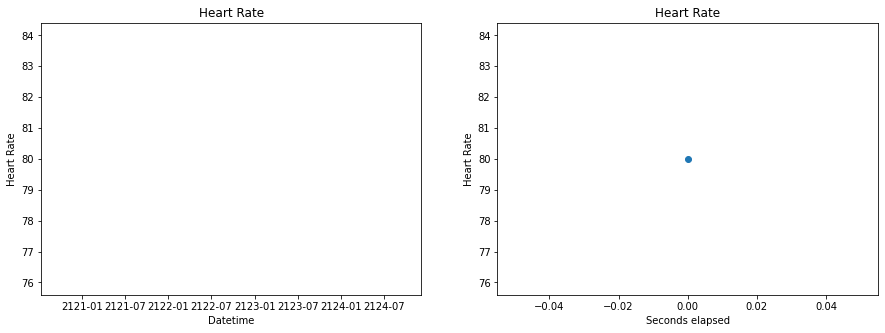

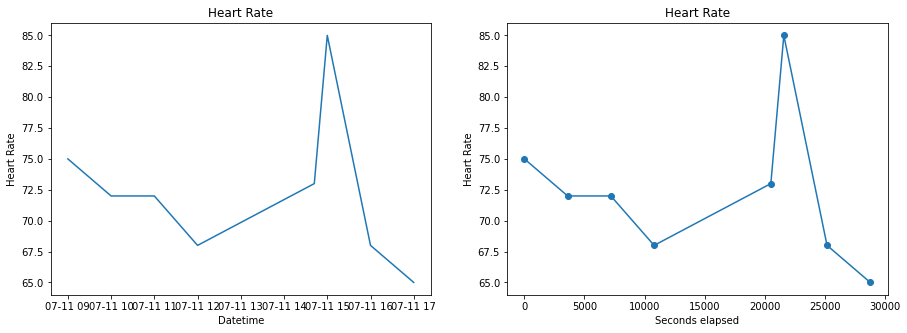

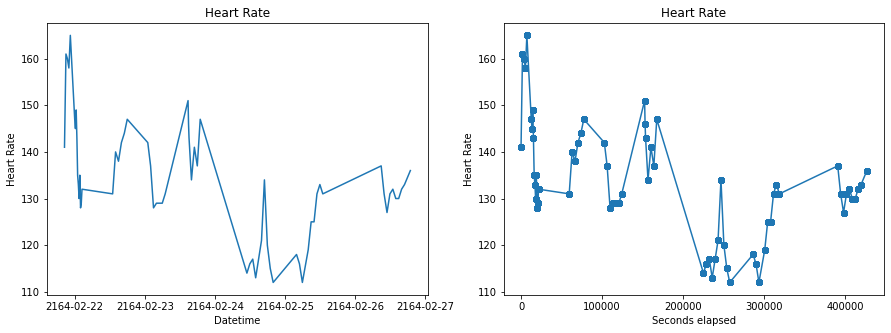

In [10]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

# Get heart rate
patients = mimic.patients()
patients_delirium = mimic.diagnoses(substring="delirium", patients=patients)
patients_delirium_heart_rate = mimic.events(
    labels="Heart Rate", patients=patients_delirium
)
patients_delirium_heart_rate.run(limit=1000)
df = patients_delirium_heart_rate.data

# Get only the labs with numeric value - This is just for now
# realistically we can find ways to utilize the other data!
df = df[df["valuenum"].notna()]

# Convert to datetime
df["charttime"] = pd.to_datetime(df["charttime"])

# Group by patient (subject_id), admission (hadm_id), ICU stay (stay_id), and event (itemid)
# NOTE: We may or may not want to group by hadm_id and/or stay_id
groupby = df.groupby(["subject_id", "hadm_id", "stay_id", "itemid"])

c = 0
for name, group in groupby:
    group.sort_values(by="charttime", inplace=True)

    label = group["label"].iloc[0]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].set_title(label)
    ax[0].plot(group["charttime"], group["valuenum"])
    ax[0].set_ylabel(label)
    ax[0].set_xlabel("Datetime")

    # Convert dates to seconds elapsed since first measurement
    group["charttime"] = (group["charttime"] - datetime.now()).dt.total_seconds()
    group["charttime"] -= group["charttime"].min()

    ax[1].set_title(label)
    ax[1].plot(group["charttime"], group["valuenum"])
    ax[1].scatter(group["charttime"], group["valuenum"])
    ax[1].set_ylabel(label)
    ax[1].set_xlabel("Seconds elapsed")
    c += 1
    if c > 2:
        break